In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

In [2]:
# load data
import pandas as pd
import numpy as np
data = pd.read_csv("profile.csv")

In [3]:
data

,bs,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170
0,4,120.968188,120.111719,121.253064,122.743604,126.865820,129.484692,147.125244,161.553198,164.939160,171.103748,171.378479,186.569006,240.242480,255.555273,257.900342,257.099683,271.332861
1,8,120.403870,123.367322,129.233411,160.569861,169.993518,183.332971,244.314941,260.732617,284.733227,306.487183,313.874634,327.409448,414.983789,422.039355,434.629834,442.882275,462.917236
2,16,125.062036,160.864661,177.031580,250.337476,302.850757,327.402075,423.451660,439.665234,469.669190,566.499023,581.031201,601.058838,705.704443,733.526611,749.396094,778.638232,879.030078
3,32,158.683435,257.854370,325.621240,435.504932,564.606543,597.130859,721.307129,778.458496,897.537305,1030.598730,1077.777539,1165.943945,1426.469043,1462.489160,1493.654102,1546.877051,1745.615625
4,48,178.896594,327.355395,467.874414,592.738086,742.165381,889.152246,1047.448242,1170.118164,1421.931641,1499.983008,1716.759570,1782.517969,2046.386328,2128.525781,2281.892383,2345.800391,2418.339648
5,64,253.610181,435.194043,591.732129,764.657764,1012.787891,1161.591602,1451.904395,1539.079980,1784.540625,2065.051367,2148.948438,2340.427344,2855.629883,2922.928125,2995.439844,3117.322266,3566.351563
6,96,332.648242,596.281250,889.196094,1161.195313,1473.751758,1774.556055,2101.549219,2327.144727,2867.281836,2985.751563,3502.100391,3637.904297,4220.819922,4533.047656,5101.176172,5222.300000,5423.337109
7,128,436.769287,768.664893,1151.299609,1521.523340,2036.398828,2326.999805,2896.173828,3105.143945,3598.352734,4403.414453,4700.318750,5283.673438,NaN,NaN,NaN,NaN,NaN
8,192,617.923389,1157.126270,1759.066797,2319.500000,2960.405859,3599.787500,4537.804297,5197.165625,6398.567578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


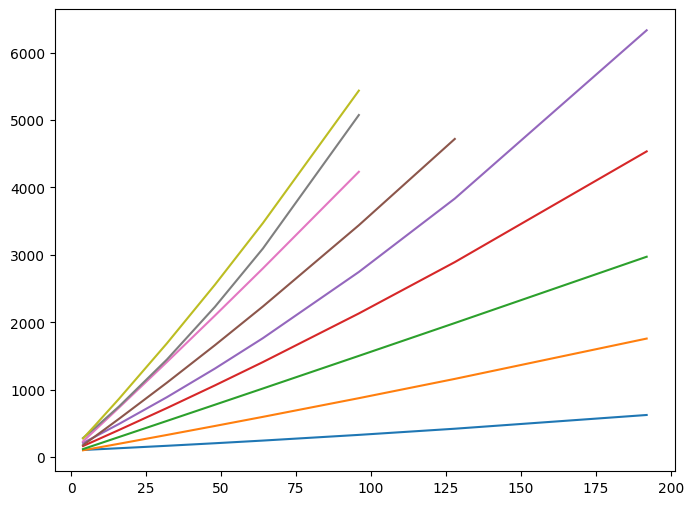

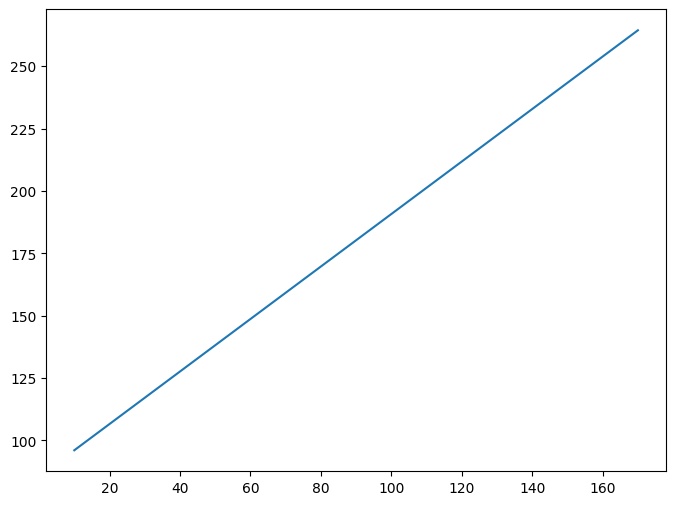

In [39]:
seq_ = list(range(10, 180, 20))
bs_ = [4,8,16,32,48,64,96,128,192] # It depends on the profiled bs list

#create a dictionary and for every seq length there should be a polynomial regression model
seq_length_models = {}

#perform regression
for seq in seq_:
    y = data[str(seq)].dropna().unique()
    x = np.array(bs_[:len(y)])
    model1 = np.poly1d(np.polyfit(x, y, 2))
    seq_length_models[seq] = model1

#plot the models
plt.figure(figsize=(8,6))
for seq in seq_:
    y = data[str(seq)].dropna().unique()
    x = np.array(bs_[:len(y)])
    plt.plot(x, seq_length_models[seq](x))


batchsize_models = {}
#perform regression
for bs in bs_:
    x = np.array(seq_)
    y = np.array([data[str(s)].values[bs_.index(bs)] for s in seq_])
    model2 = np.poly1d(np.polyfit(x, y, 1))
    batchsize_models[bs] = model2

#plot the models
plt.figure(figsize=(8,6))
for bs in [4]:
    x = np.array(seq_)
    y = np.array([data[str(s)].values[bs_.index(bs)] for s in seq_])
    plt.plot(x, batchsize_models[bs](x))

In [69]:
zeroshot_data_len = []

with open('request_lengths.txt') as f:
    for line in f:
        zeroshot_data_len.append(int(line))

print(len(zeroshot_data_len))
req_list_khan = []
zeroshot_data_len = sorted(zeroshot_data_len, reverse=True)

20164


In [94]:
def return_max_batch_size(seq_l):
    # max_batch_size is determined by GPU memory
    return min(256,17000//seq_l)

def get_bench_lat(b,s):
    t = seq_length_models[s](b)
    return b,s,t

def get_bench_lat_bs1(s):
    return batchsize_models[4](s)
    
def get_time_v100(bs, seq):
    if seq < 20:
        seq = 20

    seq_ = list(range(10, 180, 20))
    bs_ = [4,8,16,32,48,64,96,128,192,192]
    
    b_min, b_max = 1,192 # b_min should be 4 for FasterTransformer
    s_min, s_max = 10,170
    for i,b in enumerate(bs_):
        if bs <= b:
            b_max = b
            b_min = bs_[i-1]
            break
    for i,s in enumerate(seq_):
        if seq <= s:
            s_max = s
            s_min = seq_[i-1]
            break
    
    if bs == 1: # it should be 4 for FasterTransformer
        if s_max == 10: s_min = 10
        t1 = get_bench_lat_bs1(s_max)
        t2 = get_bench_lat_bs1(s_min)
        if t1==t2: res = t1
        else: res = (t2-t1)/(s_min-s_max) * (seq - s_max) + t2
    else:
        x1,y1,z1 = get_bench_lat(b_max, s_max)
        x2,y2,z2 = get_bench_lat(b_max, s_min)
        x3,y3,z3 = get_bench_lat(b_min, s_max)
        x4,y4,z4 = get_bench_lat(b_min, s_min)
            
        # esitmate latency
        A = np.linalg.det(np.array([[1, y1, z1],[1, y2, z2],[1, y3, z3]]))
        B = np.linalg.det(np.array([[x1, 1, z1],[x2, 1, z2],[x3, 1, z3]]))
        C = np.linalg.det(np.array([[x1, y1, 1],[x2, y2, 1],[x3, y3, 1]]))
        D = - np.linalg.det(np.array([[x1, y1, z1],[x2, y2, z2],[x3, y3, z3]]))

        res = -(A*bs + B*seq + D)/C
    
    if np.isnan(res): return 99999
    else: return res

In [96]:
t1 = get_time_v100(1,zeroshot_data_len[0])

batch_step = 1  # For FasterTransformer, batch_step = 4
current_batch_size = 4
current_max_seq_len = zeroshot_data_len[0]
until_index = 0

req_list_khan=[]
tot = 1
for i in range(batch_step, len(zeroshot_data_len),4):

    t2 = get_time_v100(batch_step, zeroshot_data_len[i])

    separtely = t1 + t2

    batched = get_time_v100(current_batch_size + 4, current_max_seq_len)

    gain = separtely - batched
    if gain >= 0 and current_batch_size<return_max_batch_size(current_max_seq_len): # batching them will increase the gain
        current_batch_size += batch_step
        current_max_seq_len = max(current_max_seq_len, zeroshot_data_len[i])
        t1 = batched

    else:  #batching them will decrease the gain
        if current_batch_size <= batch_step: # or current_batch_size < tot:
            current_batch_size += batch_step
            current_max_seq_len = max(current_max_seq_len, zeroshot_data_len[i])
            t1 = batched

        else:
            temp = list(range(until_index, i))
            req_list_khan.append(temp[:len(temp)//2])
            req_list_khan.append(temp[len(temp)//2:])
            tot = max(i-until_index,tot)
            until_index = i
            current_batch_size = batch_step
            current_max_seq_len = zeroshot_data_len[i]
            t1 = t2

req_list_khan.append(list(range(until_index, len(zeroshot_data_len))))

total 20164
{0: 24, 1: 24, 2: 32, 3: 32, 4: 26, 5: 26, 6: 26, 7: 26, 8: 26, 9: 26, 10: 26, 11: 26, 12: 26, 13: 26, 14: 26, 15: 26, 16: 26, 17: 26, 18: 26, 19: 26, 20: 26, 21: 26, 22: 26, 23: 26, 24: 26, 25: 26, 26: 26, 27: 26, 28: 26, 29: 26, 30: 26, 31: 26, 32: 26, 33: 26, 34: 26, 35: 26, 36: 26, 37: 26, 38: 26, 39: 26, 40: 26, 41: 26, 42: 26, 43: 26, 44: 26, 45: 26, 46: 26, 47: 26, 48: 26, 49: 26, 50: 26, 51: 26, 52: 26, 53: 26, 54: 26, 55: 26, 56: 26, 57: 26, 58: 26, 59: 26, 60: 66, 61: 66, 62: 66, 63: 66, 64: 66, 65: 66, 66: 66, 67: 66, 68: 68, 69: 68, 70: 68, 71: 68, 72: 68, 73: 68, 74: 68, 75: 68, 76: 68, 77: 68, 78: 70, 79: 70, 80: 70, 81: 70, 82: 70, 83: 70, 84: 66, 85: 66, 86: 66, 87: 66, 88: 66, 89: 66, 90: 66, 91: 66, 92: 66, 93: 66, 94: 66, 95: 66, 96: 66, 97: 66, 98: 66, 99: 66, 100: 66, 101: 66, 102: 66, 103: 66, 104: 66, 105: 66, 106: 66, 107: 66, 108: 66, 109: 66, 110: 66, 111: 66, 112: 66, 113: 66, 114: 66, 115: 66, 116: 66, 117: 66, 118: 50, 119: 50, 120: 50, 121: 50,

Text(0.5, 1.0, 'Distribution of Batch Sizes')

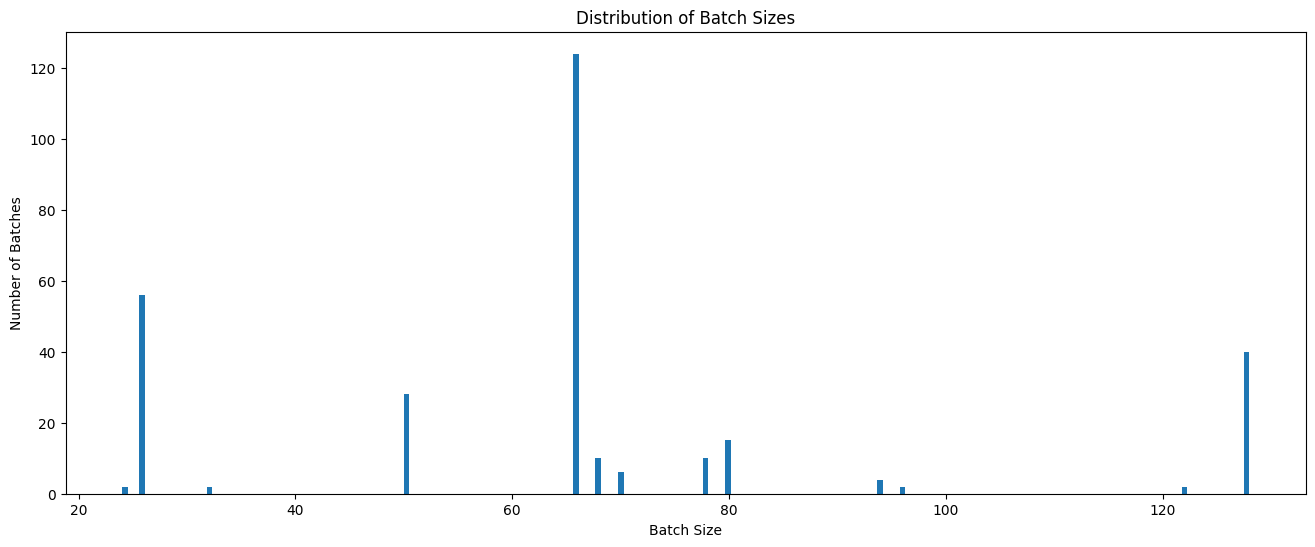

In [97]:
len(req_list_khan)

req_list_khan_dict = {}
cnt = 0
for i in range(len(req_list_khan)):
    req_list_khan_dict[i] = len(req_list_khan[i])
    cnt += req_list_khan_dict[i]

print("total", cnt)
print(req_list_khan_dict)
#plot the distribution of the batch sizes

plt.figure(figsize=(16,6))

plt.hist(req_list_khan_dict.values(), bins=200)
plt.xlabel('Batch Size')
plt.ylabel('Number of Batches')
plt.title('Distribution of Batch Sizes')

In [98]:
def unique(list1):
    x = np.array(list1)
    return np.unique(x)

print(unique(req_list_khan_dict.values()))

#save it as a dcit file for later use
import pickle

with open('greedy.pickle', 'wb') as handle:
    pickle.dump(req_list_khan_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

[dict_values([24, 24, 32, 32, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 66, 66, 66, 66, 66, 66, 66, 66, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 70, 70, 70, 70, 70, 70, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 78, 78, 78, 78, 78, 78, 78, 78, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 78, 78, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 50, 50, 94, 94, 94, 94, 96, 96, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66